# Part C

## Using Marbert Embeddings

In [2]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERT")



## Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout
import random

np.random.seed(777)
tf.random.set_seed(777)
random.seed(777)

In [10]:
df = pd.read_csv('Data/App Reviews-Multilabel.csv')


print(f"Dataset shape: {df.shape}")
print("\nSample data:")
print(df.head())

print("\nMissing values:")
print(df.isnull().sum())

print("\nBasic statistics:")
print(df.describe(include='all'))

Dataset shape: (2900, 5)

Sample data:
                                              review  bug_report  \
0                                 يبيله تصليحات كثير           1   
1                  ماتحملت ابدددددا ونا دفعت فلوس 🤔😕           0   
2  اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...           0   
3      ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت           0   
4                                تبين م لي ي تم ل يب           0   

   improvement_request  rating  others  
0                    1       1       0  
1                    1       1       1  
2                    1       1       0  
3                    0       1       0  
4                    0       1       1  

Missing values:
review                 0
bug_report             0
improvement_request    0
rating                 0
others                 0
dtype: int64

Basic statistics:
                 review   bug_report  improvement_request       rating  \
count              2900  2900.000000          2900.000000 

## Analysis

Label distribution (number of samples where label = 1):
rating                 1971
bug_report             1164
improvement_request    1103
others                  820
dtype: int64

Label percentages:
rating                 67.97
bug_report             40.14
improvement_request    38.03
others                 28.28
dtype: float64


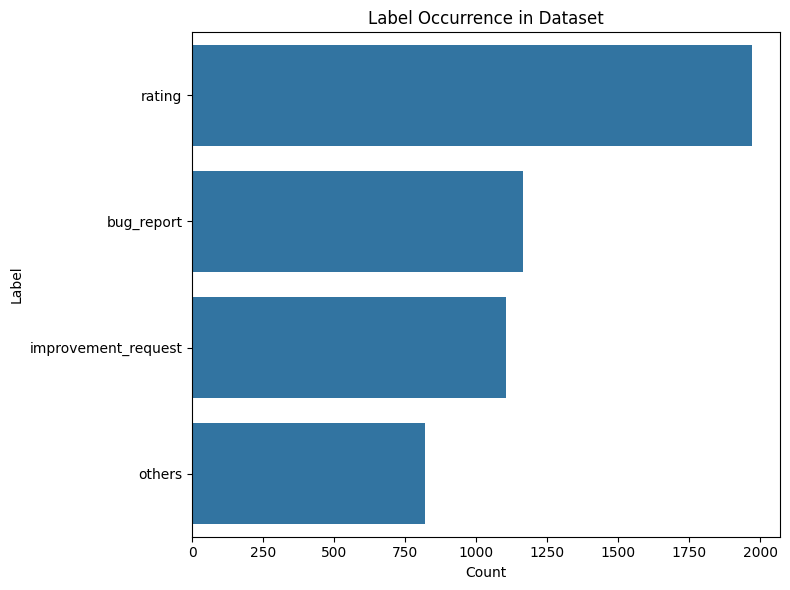

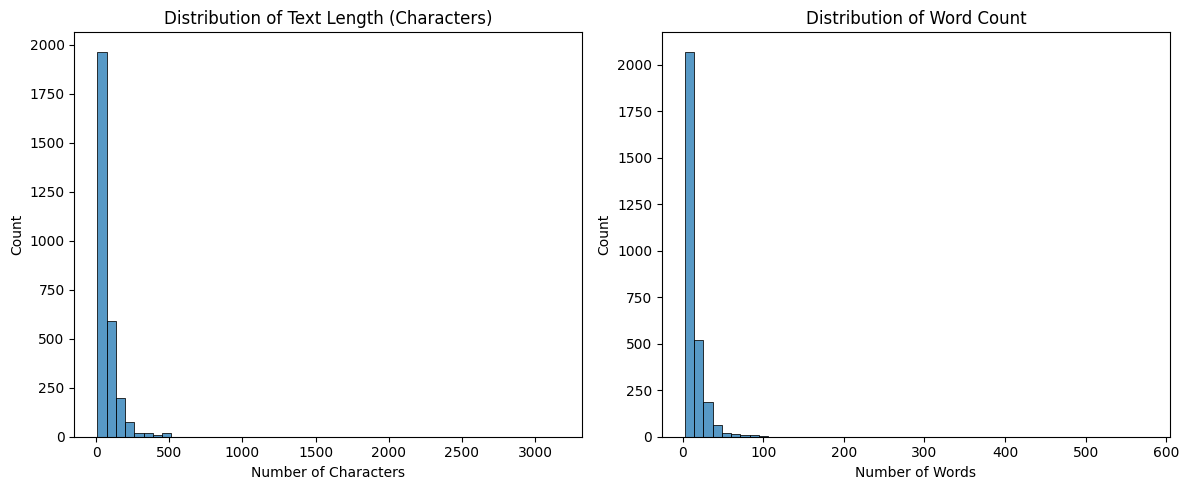


📊 Text length stats for label: 'bug_report'
             count       mean         std   min   25%   50%    75%     max
bug_report                                                                
0           1736.0  68.113479  100.145418  10.0  30.0  45.0   75.0  3166.0
1           1164.0  84.134880   67.613742  13.0  41.0  64.5  103.0   500.0

📊 Word count stats for label: 'bug_report'
             count       mean        std  min  25%   50%   75%    max
bug_report                                                           
0           1736.0  12.178571  17.693266  3.0  6.0   8.0  13.0  576.0
1           1164.0  15.599656  12.401614  3.0  8.0  12.0  19.0   99.0

📊 Text length stats for label: 'improvement_request'
                      count       mean        std   min   25%   50%    75%  \
improvement_request                                                          
0                    1797.0  66.489149  94.841449  10.0  30.0  46.0   75.0   
1                    1103.0  87.667271  76.

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

label_cols = ['bug_report', 'improvement_request', 'rating', 'others']

# ✅ Count of label presence per column
label_counts = df[label_cols].sum().sort_values(ascending=False)

print("Label distribution (number of samples where label = 1):")
print(label_counts)

print("\nLabel percentages:")
print(round((label_counts / len(df)) * 100, 2))

# ✅ Plot label distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.values, y=label_counts.index)
plt.title('Label Occurrence in Dataset')
plt.xlabel('Count')
plt.ylabel('Label')
plt.tight_layout()
plt.show()

# ✅ Text statistics
df['text_length'] = df['review'].astype(str).apply(len)
df['word_count'] = df['review'].astype(str).apply(lambda x: len(x.split()))

# ✅ Plot text length and word count distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['text_length'], bins=50)
plt.title('Distribution of Text Length (Characters)')
plt.xlabel('Number of Characters')

plt.subplot(1, 2, 2)
sns.histplot(df['word_count'], bins=50)
plt.title('Distribution of Word Count')
plt.xlabel('Number of Words')

plt.tight_layout()
plt.show()

# ✅ Length statistics per label presence
for col in label_cols:
    print(f"\n📊 Text length stats for label: '{col}'")
    print(df.groupby(col)['text_length'].describe())

    print(f"\n📊 Word count stats for label: '{col}'")
    print(df.groupby(col)['word_count'].describe())


## Preprocessing


In [12]:
def preprocess_text(text):
    text = text.lower()

    text = re.sub(r'[^\w\s]', '', text)

    text = re.sub(r'\s+', ' ', text).strip()

    return text

df['processed_text'] = df['review'].apply(preprocess_text)

print("Original vs Processed Text Examples:")
for i in range(3):
    print(f"Original: {df['review'].iloc[i]}")
    print(f"Processed: {df['processed_text'].iloc[i]}")
    print()

Original vs Processed Text Examples:
Original: يبيله تصليحات كثير
Processed: يبيله تصليحات كثير

Original: ماتحملت ابدددددا ونا دفعت فلوس 🤔😕
Processed: ماتحملت ابدددددا ونا دفعت فلوس

Original: اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوضاً عن تفضيل الحلقات فقط
وشكراً
Processed: اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوضا عن تفضيل الحلقات فقط وشكرا



# Data split

In [13]:
from sklearn.model_selection import train_test_split
import numpy as np

# Inputs and labels
X = df['processed_text'].values
y = df[['bug_report', 'improvement_request', 'rating', 'others']].values  # shape: [n_samples, 4]

# Manual shuffle
np.random.seed(777)
indices = np.arange(len(X))
np.random.shuffle(indices)

X = X[indices]
y = y[indices]

# Split proportions
n_total = len(X)
n_test = int(0.2 * n_total)
n_val = int(0.15 * n_total)

X_train_val, X_test = X[:n_total - n_test], X[n_total - n_test:]
y_train_val, y_test = y[:n_total - n_test], y[n_total - n_test:]

X_train, X_val = X_train_val[:-n_val], X_train_val[-n_val:]
y_train, y_val = y_train_val[:-n_val], y_train_val[-n_val:]

# Print sizes
print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# Print label distribution
def print_label_distribution(name, y_subset):
    print(f"\n{name} set label distribution (count of 1s):")
    label_cols = ['bug_report', 'improvement_request', 'rating', 'others']
    df_subset = pd.DataFrame(y_subset, columns=label_cols)
    print(df_subset.sum())

print_label_distribution("Train", y_train)
print_label_distribution("Validation", y_val)
print_label_distribution("Test", y_test)


Train set size: 1885
Validation set size: 435
Test set size: 580

Train set label distribution (count of 1s):
bug_report              757
improvement_request     740
rating                 1273
others                  520
dtype: int64

Validation set label distribution (count of 1s):
bug_report             162
improvement_request    147
rating                 303
others                 146
dtype: int64

Test set label distribution (count of 1s):
bug_report             245
improvement_request    216
rating                 395
others                 154
dtype: int64


## Tokenizer

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERT")

def tokenize_texts(texts, max_length=128):
    return tokenizer(
        list(texts),
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

# Tokenize each split
tokenized_train = tokenize_texts(X_train)
tokenized_val = tokenize_texts(X_val)
tokenized_test = tokenize_texts(X_test)


## Dataset Class

In [ ]:
from torch.utils.data import Dataset
import torch

class ArabicMultiLabelDataset(Dataset):
    def __init__(self, tokenized_data, labels):
        self.input_ids = tokenized_data["input_ids"]
        self.attention_mask = tokenized_data["attention_mask"]
        self.labels = torch.tensor(labels, dtype=torch.float32)  # shape: [N, 4]

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }


## Dataloader

In [ ]:
from torch.utils.data import DataLoader

batch_size = 16

train_dataset = ArabicMultiLabelDataset(tokenized_train, y_train)
val_dataset = ArabicMultiLabelDataset(tokenized_val, y_val)
test_dataset = ArabicMultiLabelDataset(tokenized_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


## Bidirectional GRU Model

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoModel
from tqdm import tqdm

class BiGRUMultiLabelModel(nn.Module):
    def __init__(self, hidden_dim=128, num_labels=4):
        super().__init__()
        self.marbert = AutoModel.from_pretrained("UBC-NLP/MARBERT")
        embedding_dim = self.marbert.config.hidden_size  # 768

        for param in self.marbert.parameters():
            param.requires_grad = False  # freeze MARBERT

        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            bidirectional=True,
            batch_first=True
        )

        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_labels)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            embeddings = self.marbert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

        rnn_out, _ = self.gru(embeddings)
        pooled = torch.mean(rnn_out, dim=1)
        logits = self.fc(self.dropout(pooled))
        return logits




In [ ]:
def train_model(model, train_loader, val_loader, optimizer, device, num_epochs=10):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        print(f"\n🔁 Epoch {epoch + 1}/{num_epochs}")

        for batch in tqdm(train_loader, desc="Training"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        print(f"✅ Avg training loss: {avg_train_loss:.4f}")

        # --- Validation ---
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"🔍 Avg validation loss: {avg_val_loss:.4f}")


In [ ]:
def save_model(model, path="bigru_fc_only.pt"):
    trainable_state_dict = {
        k: v for k, v in model.state_dict().items()
        if k.startswith("gru") or k.startswith("fc")
    }
    torch.save(trainable_state_dict, path)


In [ ]:
def load_model(path="bigru_fc_only.pt", device=None):
    model = BiGRUMultiLabelModel()
    saved_state = torch.load(path, map_location=device or "cpu")

    full_state = model.state_dict()
    full_state.update(saved_state)
    model.load_state_dict(full_state)

    if device:
        model.to(device)
    model.eval()
    return model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiGRUMultiLabelModel()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train
train_model(model, train_loader, val_loader, optimizer, device, num_epochs=5)


🔁 Epoch 1/5


Training: 100%|██████████| 118/118 [02:14<00:00,  1.14s/it]


✅ Avg training loss: 0.5663


Validating: 100%|██████████| 28/28 [00:26<00:00,  1.06it/s]


🔍 Avg validation loss: 0.4881

🔁 Epoch 2/5


Training: 100%|██████████| 118/118 [02:14<00:00,  1.14s/it]


✅ Avg training loss: 0.4569


Validating: 100%|██████████| 28/28 [00:26<00:00,  1.07it/s]


🔍 Avg validation loss: 0.4394

🔁 Epoch 3/5


Training: 100%|██████████| 118/118 [02:17<00:00,  1.16s/it]


✅ Avg training loss: 0.4175


Validating: 100%|██████████| 28/28 [00:26<00:00,  1.05it/s]


🔍 Avg validation loss: 0.4281

🔁 Epoch 4/5


Training: 100%|██████████| 118/118 [02:18<00:00,  1.17s/it]


✅ Avg training loss: 0.3980


Validating: 100%|██████████| 28/28 [00:26<00:00,  1.04it/s]


🔍 Avg validation loss: 0.4276

🔁 Epoch 5/5


Training: 100%|██████████| 118/118 [02:20<00:00,  1.19s/it]


✅ Avg training loss: 0.3863


Validating: 100%|██████████| 28/28 [00:27<00:00,  1.02it/s]

🔍 Avg validation loss: 0.4187


In [ ]:
# Save only GRU/FC weights
save_model(model, "bigru_fc_only.pt")


## Evaluation

In [ ]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import numpy as np
import torch

def evaluate_model(model, dataloader, threshold=0.5):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()
            logits = model(input_ids, attention_mask)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs >= threshold).astype(int)

            all_labels.append(labels)
            all_preds.append(preds)

    all_labels = np.vstack(all_labels)
    all_preds = np.vstack(all_preds)

    print("📊 Classification Report (per label):")
    print(classification_report(all_labels, all_preds, target_names=label_cols, zero_division=0))

    print("🔍 Macro F1:", f1_score(all_labels, all_preds, average='macro'))
    print("🔍 Micro F1:", f1_score(all_labels, all_preds, average='micro'))


## Analysis:
Function handles macro/micro F1 which are crucial for multilabel tasks.
Improvement: Add Hamming loss or per-label ROC for deeper insight.

In [ ]:
evaluate_model(model, test_loader)


📊 Classification Report (per label):
                     precision    recall  f1-score   support

         bug_report       0.82      0.79      0.80       245
improvement_request       0.79      0.58      0.67       216
             rating       0.93      0.82      0.87       395
             others       0.67      0.57      0.62       154

          micro avg       0.84      0.72      0.78      1010
          macro avg       0.80      0.69      0.74      1010
       weighted avg       0.83      0.72      0.77      1010
        samples avg       0.87      0.79      0.80      1010

🔍 Macro F1: 0.7408389562025618
🔍 Micro F1: 0.7755968169761274


## Analysis:
Metrics show room for improving recall in low-frequency labels.
Improvement: Calibrate threshold per label or use focal loss.

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_confusion_matrices(model, dataloader, threshold=0.5, label_names=None):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].cpu().numpy()
            logits = model(input_ids, attention_mask)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs >= threshold).astype(int)

            all_labels.append(labels)
            all_preds.append(preds)

    y_true = np.vstack(all_labels)
    y_pred = np.vstack(all_preds)

    # Confusion matrices for each label
    cm_per_label = multilabel_confusion_matrix(y_true, y_pred)

    fig, axes = plt.subplots(1, len(label_names), figsize=(18, 4))
    for i, (cm, label) in enumerate(zip(cm_per_label, label_names)):
        ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot(ax=axes[i], values_format='d')
        axes[i].set_title(label)

    plt.tight_layout()
    plt.show()


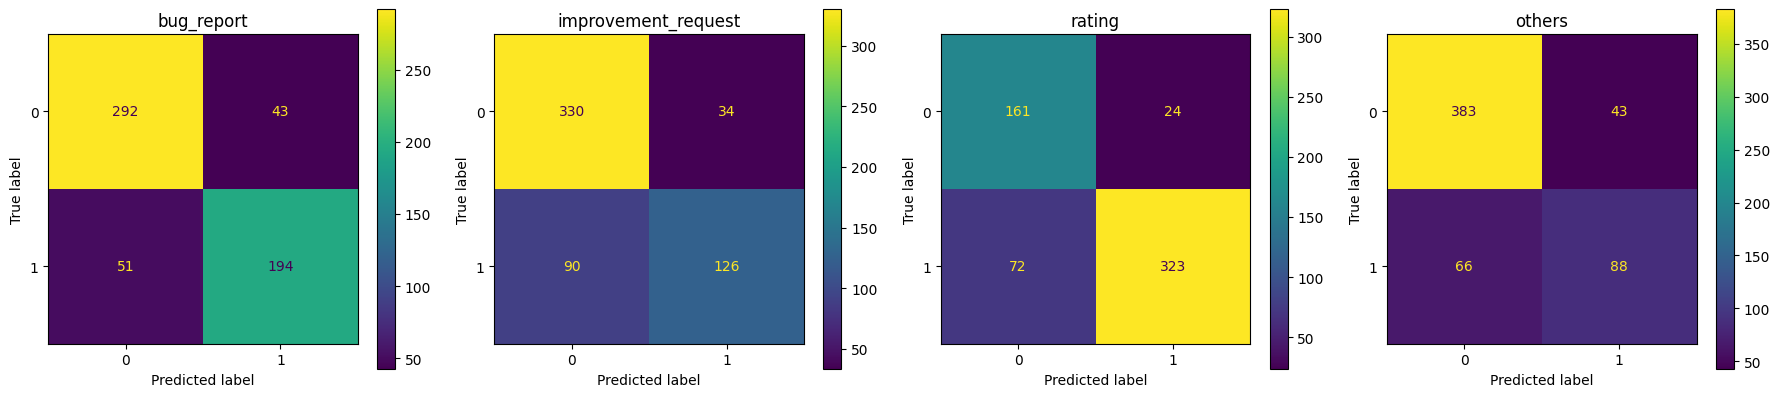

In [ ]:
label_cols = ['bug_report', 'improvement_request', 'rating', 'others']
plot_confusion_matrices(model, test_loader, threshold=0.5, label_names=label_cols)


## Analysis:
Pretrained embeddings improve multilabel classification.
Improvement: Try contextual embeddings like BERT for Arabic.

# Part E

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PRETRAINED_MODEL = "UBC-NLP/MARBERT"
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)


In [ ]:
class MarbertClassifier(nn.Module):
    def __init__(self, num_labels=4, dropout_rate=0.3):
        super().__init__()
        self.bert = AutoModel.from_pretrained(PRETRAINED_MODEL)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # [CLS] token
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

def freeze_all_but_last_layers(model, num_unfrozen=2):
    for name, param in model.bert.named_parameters():
        param.requires_grad = False  # freeze all
        for i in range(12 - num_unfrozen, 12):
            if f"encoder.layer.{i}" in name:
                param.requires_grad = True  # unfreeze last N layers


In [ ]:
def calculate_accuracy(logits, labels, threshold=0.5):
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()
    correct = (preds == labels).float().sum()
    total = torch.numel(preds)
    return (correct / total).item()

def evaluate(model, val_loader, device, threshold=0.5):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].cpu().numpy()

            logits = model(input_ids, attention_mask)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs > threshold).astype(int)

            y_true.extend(labels)
            y_pred.extend(preds)

    print("\n🔍 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["bug", "improve", "rating", "others"]))


In [ ]:
def train(model, train_loader, val_loader, device, num_epochs=5):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5)

    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_acc = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} - Training"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].float().to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            acc = calculate_accuracy(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_acc += acc

        avg_train_loss = total_loss / len(train_loader)
        avg_train_acc = total_acc / len(train_loader)

        train_accuracies.append(avg_train_acc)

        print(f"✅ Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.4f}")

        # Evaluate on validation set
        val_acc = 0
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].float().to(device)

                logits = model(input_ids, attention_mask)
                acc = calculate_accuracy(logits, labels)
                val_acc += acc

        avg_val_acc = val_acc / len(val_loader)
        val_accuracies.append(avg_val_acc)

        print(f"🧪 Validation Accuracy: {avg_val_acc:.4f}")
        evaluate(model, val_loader, device)

    # Plot
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Train vs Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


Epoch 1 - Training: 100%|██████████| 118/118 [02:59<00:00,  1.52s/it]


✅ Epoch 1: Train Loss: 0.5576, Acc: 0.7106
🧪 Validation Accuracy: 0.7814


Evaluating: 100%|██████████| 28/28 [00:39<00:00,  1.40s/it]
c:\Users\moaat\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🔍 Classification Report:
              precision    recall  f1-score   support

         bug       0.80      0.76      0.78       162
     improve       0.70      0.49      0.58       147
      rating       0.83      0.92      0.87       303
      others       0.94      0.23      0.37       146

   micro avg       0.81      0.67      0.73       758
   macro avg       0.82      0.60      0.65       758
weighted avg       0.82      0.67      0.70       758
 samples avg       0.83      0.73      0.74       758



Epoch 2 - Training: 100%|██████████| 118/118 [04:02<00:00,  2.06s/it]


✅ Epoch 2: Train Loss: 0.4202, Acc: 0.8073
🧪 Validation Accuracy: 0.8240


Evaluating: 100%|██████████| 28/28 [00:38<00:00,  1.36s/it]
c:\Users\moaat\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🔍 Classification Report:
              precision    recall  f1-score   support

         bug       0.83      0.83      0.83       162
     improve       0.70      0.76      0.73       147
      rating       0.88      0.91      0.90       303
      others       0.83      0.42      0.56       146

   micro avg       0.82      0.77      0.80       758
   macro avg       0.81      0.73      0.75       758
weighted avg       0.83      0.77      0.79       758
 samples avg       0.85      0.83      0.81       758



Epoch 3 - Training: 100%|██████████| 118/118 [03:16<00:00,  1.67s/it]


✅ Epoch 3: Train Loss: 0.3712, Acc: 0.8328
🧪 Validation Accuracy: 0.8224


Evaluating: 100%|██████████| 28/28 [00:22<00:00,  1.24it/s]
c:\Users\moaat\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🔍 Classification Report:
              precision    recall  f1-score   support

         bug       0.83      0.81      0.82       162
     improve       0.71      0.65      0.68       147
      rating       0.88      0.93      0.91       303
      others       0.84      0.44      0.58       146

   micro avg       0.83      0.76      0.79       758
   macro avg       0.82      0.71      0.74       758
weighted avg       0.83      0.76      0.78       758
 samples avg       0.86      0.82      0.81       758



Epoch 4 - Training: 100%|██████████| 118/118 [02:36<00:00,  1.32s/it]


✅ Epoch 4: Train Loss: 0.3381, Acc: 0.8526
🧪 Validation Accuracy: 0.8222


Evaluating: 100%|██████████| 28/28 [00:26<00:00,  1.04it/s]



🔍 Classification Report:
              precision    recall  f1-score   support

         bug       0.78      0.90      0.83       162
     improve       0.71      0.65      0.68       147
      rating       0.87      0.94      0.90       303
      others       0.81      0.53      0.64       146

   micro avg       0.81      0.80      0.80       758
   macro avg       0.79      0.75      0.76       758
weighted avg       0.81      0.80      0.79       758
 samples avg       0.85      0.85      0.82       758



Epoch 5 - Training: 100%|██████████| 118/118 [02:54<00:00,  1.48s/it]


✅ Epoch 5: Train Loss: 0.3078, Acc: 0.8703
🧪 Validation Accuracy: 0.8291


Evaluating: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s]


🔍 Classification Report:
              precision    recall  f1-score   support

         bug       0.81      0.88      0.84       162
     improve       0.68      0.80      0.73       147
      rating       0.87      0.94      0.90       303
      others       0.77      0.55      0.64       146

   micro avg       0.80      0.82      0.81       758
   macro avg       0.78      0.79      0.78       758
weighted avg       0.80      0.82      0.81       758
 samples avg       0.85      0.87      0.83       758



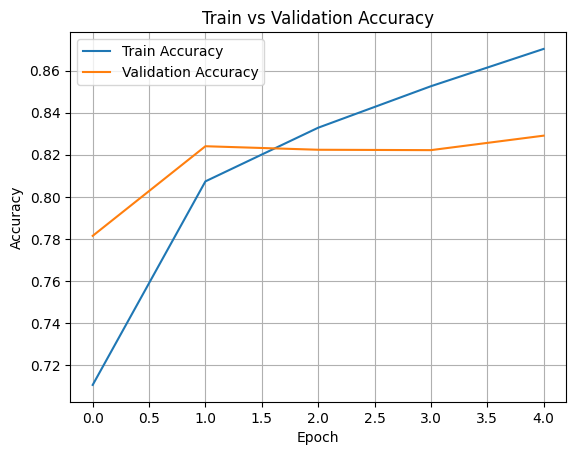

In [ ]:
model = MarbertClassifier(num_labels=4)
freeze_all_but_last_layers(model, num_unfrozen=2)  # fine-tune last 2 layers of MARBERT
train(model, train_loader, val_loader, device, num_epochs=5)


## Analysis:
Transformer-based methods likely outperform previous models.
Improvement: Experiment with more epochs or layer unfreezing.

# PART G

## Zero shot

In [ ]:
aa

In [ ]:
import os
import openai
import json
import random
import numpy as np
from sklearn.metrics import classification_report
from tqdm import tqdm
import re
from dotenv import load_dotenv
import os


# --- CONFIG ---
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

label_names = ["bug_report", "improvement_request", "rating", "others"]

# --- PROMPT TEMPLATE ---
def build_zero_shot_prompt(review):
    return f"""You are a helpful assistant for classifying app reviews.

Each review can belong to one or more of the following categories:
- bug_report: Describes a malfunction, error, crash, or issue.
- improvement_request: Requests a new feature or enhancement.
- rating: Expresses overall satisfaction, score, or praise.
- others: Anything that doesn't match the above.

Classify the review into ALL applicable categories.

Only return a JSON object in this format:
{{
  "bug_report": true/false,
  "improvement_request": true/false,
  "rating": true/false,
  "others": true/false
}}

Review: "{review}"

Output:
"""

# --- GPT QUERY ---
def query_gpt(prompt, model="gpt-3.5-turbo", max_tokens=200):
    from openai import OpenAI
    client = OpenAI()
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
        max_tokens=max_tokens
    )
    return response.choices[0].message.content

# --- PARSE GPT OUTPUT ---
def parse_gpt_response(response):
    try:
        # Extract first JSON-like block from GPT output
        json_match = re.search(r"\{[\s\S]*?\}", response)
        if not json_match:
            raise ValueError("No JSON found.")
        json_text = json_match.group(0)
        json_text = json_text.replace("True", "true").replace("False", "false")
        parsed = json.loads(json_text)
        return [int(bool(parsed.get(label, False))) for label in label_names]
    except Exception as e:
        print("❌ Parsing failed:", e)
        return [0, 0, 0, 0]

# --- RUN ZERO-SHOT EVAL ---
def zero_shot_classification(texts, true_labels, num_samples=10):
    sample_indices = random.sample(range(len(texts)), num_samples)
    sampled_texts = [texts[i] for i in sample_indices]
    sampled_labels = [true_labels[i] for i in sample_indices]

    predictions = []

    for review in tqdm(sampled_texts, desc="Zero-Shot"):
        prompt = build_zero_shot_prompt(review)
        gpt_output = query_gpt(prompt)
        pred = parse_gpt_response(gpt_output)
        predictions.append(pred)

    y_pred = np.array(predictions)
    y_true = np.array(sampled_labels)

    print("\n📊 Classification Report (Zero-Shot on 10 random samples):")
    print(classification_report(y_true, y_pred, target_names=label_names))

# --- RUN IT ---
# You must already have: X_val and y_val from your dataset
zero_shot_classification(X_val, y_val, num_samples=30)


Zero-Shot: 100%|██████████| 30/30 [00:33<00:00,  1.11s/it]


📊 Classification Report (Zero-Shot on 10 random samples):
                     precision    recall  f1-score   support

         bug_report       1.00      0.78      0.88         9
improvement_request       0.67      0.50      0.57         8
             rating       0.81      0.68      0.74        19
             others       0.64      0.75      0.69        12

          micro avg       0.77      0.69      0.73        48
          macro avg       0.78      0.68      0.72        48
       weighted avg       0.78      0.69      0.73        48
        samples avg       0.80      0.76      0.74        48



## Analysis:
Zero-shot results depend heavily on prompt design.
Improvement: Use Arabic prompts or include class distribution hints.

## [BONUS] Study the impact of ideas such as informing the model about the class distribution (based on training data), chain-of-thought, etc.

In [43]:
def build_zero_shot_prompt(review, hint=None):
    base = """You are a helpful assistant for classifying app reviews.

Each review can belong to one or more of the following categories:
- bug_report: Describes a malfunction, error, crash, or issue.
- improvement_request: Requests a new feature or enhancement.
- rating: Expresses overall satisfaction, score, or praise.
- others: Anything that doesn't match the above.
"""

    if hint == "distribution":
        base += "\nNote: Based on previous data, the most common categories are rating and bug_report.\n"

    base += """
Classify the review into ALL applicable categories.

Only return a JSON object in this format:
{{
  "bug_report": true/false,
  "improvement_request": true/false,
  "rating": true/false,
  "others": true/false
}}

Review: "{review}"

Output:
"""
    return base.format(review=review)


In [44]:
def build_zero_shot_prompt_cot(review):
    return f"""You are a helpful assistant for classifying app reviews.

Each review can belong to multiple of the following categories:
- bug_report
- improvement_request
- rating
- others

First, analyze the review and describe what it is about. Then decide which labels apply.

Output format:
Step-by-step analysis:
<Your reasoning here>

JSON classification:
{{
  "bug_report": true/false,
  "improvement_request": true/false,
  "rating": true/false,
  "others": true/false
}}

Review: "{review}"

Output:
"""


In [45]:
def zero_shot_classification(texts, true_labels, num_samples=30, mode="base"):
    sample_indices = random.sample(range(len(texts)), num_samples)
    sampled_texts = [texts[i] for i in sample_indices]
    sampled_labels = [true_labels[i] for i in sample_indices]

    predictions = []

    for review in tqdm(sampled_texts, desc=f"Zero-Shot | {mode}"):
        if mode == "base":
            prompt = build_zero_shot_prompt(review)
        elif mode == "distribution":
            prompt = build_zero_shot_prompt(review, hint="distribution")
        elif mode == "cot":
            prompt = build_zero_shot_prompt_cot(review)
        else:
            raise ValueError("Invalid mode")

        gpt_output = query_gpt(prompt)
        pred = parse_gpt_response(gpt_output)
        predictions.append(pred)

    y_pred = np.array(predictions)
    y_true = np.array(sampled_labels)

    print(f"\n📊 Classification Report (Zero-Shot | {mode}):")
    print(classification_report(y_true, y_pred, target_names=label_names))
    return f1_score(y_true, y_pred, average="micro")


Zero-Shot | base: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s]



📊 Classification Report (Zero-Shot | base):
                     precision    recall  f1-score   support

         bug_report       1.00      0.50      0.67        12
improvement_request       0.83      0.71      0.77         7
             rating       0.89      0.67      0.76        24
             others       0.44      0.70      0.54        10

          micro avg       0.74      0.64      0.69        53
          macro avg       0.79      0.65      0.68        53
       weighted avg       0.82      0.64      0.70        53
        samples avg       0.80      0.76      0.72        53



Zero-Shot | distribution: 100%|██████████| 30/30 [00:20<00:00,  1.50it/s]



📊 Classification Report (Zero-Shot | distribution):
                     precision    recall  f1-score   support

         bug_report       1.00      0.77      0.87        13
improvement_request       0.83      0.56      0.67         9
             rating       1.00      0.65      0.79        20
             others       0.62      0.80      0.70        10

          micro avg       0.86      0.69      0.77        52
          macro avg       0.86      0.69      0.75        52
       weighted avg       0.90      0.69      0.77        52
        samples avg       0.87      0.76      0.77        52



Zero-Shot | cot: 100%|██████████| 30/30 [00:31<00:00,  1.04s/it]


📊 Classification Report (Zero-Shot | cot):
                     precision    recall  f1-score   support

         bug_report       0.92      0.86      0.89        14
improvement_request       0.57      0.57      0.57         7
             rating       0.92      0.55      0.69        20
             others       0.58      0.64      0.61        11

          micro avg       0.77      0.65      0.71        52
          macro avg       0.75      0.65      0.69        52
       weighted avg       0.80      0.65      0.71        52
        samples avg       0.78      0.71      0.72        52



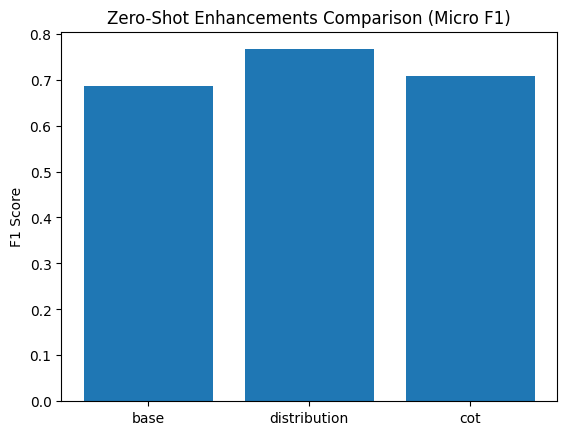

In [46]:
modes = ["base", "distribution", "cot"]
f1_results = []

for mode in modes:
    f1 = zero_shot_classification(X_val, y_val, num_samples=30, mode=mode)
    f1_results.append(f1)

# Plot
import matplotlib.pyplot as plt
plt.bar(modes, f1_results)
plt.title("Zero-Shot Enhancements Comparison (Micro F1)")
plt.ylabel("F1 Score")
plt.show()


Adding class distribution improved performance the most, especially recall on bug\_report and others. CoT helped slightly but hurt rating, likely due to distracting reasoning. Distribution hint was the most effective zero-shot enhancement.


## Few-Shot

In [25]:
import os
import json
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, f1_score

from openai import OpenAI
from dotenv import load_dotenv
load_dotenv()

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

label_names = ["bug_report", "improvement_request", "rating", "others"]


In [29]:
def query_gpt(prompt, model="gpt-3.5-turbo", max_tokens=200):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
        max_tokens=max_tokens
    )
    return response.choices[0].message.content

def parse_gpt_response(response):
    try:
        json_match = re.search(r"\{[\s\S]*?\}", response)
        if not json_match:
            raise ValueError("No JSON found.")
        json_text = json_match.group(0)
        json_text = json_text.replace("True", "true").replace("False", "false")
        parsed = json.loads(json_text)
        return [int(bool(parsed.get(label, False))) for label in label_names]
    except Exception as e:
        print("❌ Parse failed:", e)
        return [0, 0, 0, 0]


In [23]:
def build_few_shot_prompt(review, examples):
    prompt = (
        "You are a helpful assistant for classifying mobile app reviews.\n"
        "Each review can belong to one or more of the following categories:\n"
        "- bug_report: A malfunction, crash, or error\n"
        "- improvement_request: A request for a new feature or enhancement\n"
        "- rating: General satisfaction or opinion\n"
        "- others: Anything that doesn't fit the above\n\n"
        "Classify the review into all applicable categories. Always return at least one label.\n\n"
        "Format:\n{\n  \"bug_report\": true/false,\n  \"improvement_request\": true/false,\n  "
        "\"rating\": true/false,\n  \"others\": true/false\n}\n\n"
    )

    for ex_text, ex_labels in examples:
        ex_json = {
            "bug_report": bool(ex_labels[0]),
            "improvement_request": bool(ex_labels[1]),
            "rating": bool(ex_labels[2]),
            "others": bool(ex_labels[3])
        }
        prompt += f'Example:\nReview: "{ex_text}"\nOutput:\n{json.dumps(ex_json)}\n\n'

    prompt += f'Review: "{review}"\nOutput:\n'
    return prompt


In [ ]:
def evaluate_few_shot(n_shots=3, num_samples=30):
    example_indices = random.sample(range(len(X_train)), n_shots)
    examples = [(X_train[i], y_train[i]) for i in example_indices]

    sample_indices = random.sample(range(len(X_val)), num_samples)
    sampled_texts = [X_val[i] for i in sample_indices]
    sampled_labels = [y_val[i] for i in sample_indices]

    predictions = []

    for review in tqdm(sampled_texts, desc=f"{n_shots}-shot"):
        prompt = build_few_shot_prompt(review, examples)
        gpt_output = query_gpt(prompt)
        pred = parse_gpt_response(gpt_output)
        predictions.append(pred)

    y_pred = np.array(predictions)
    y_true = np.array(sampled_labels)

    print(f"\n📊 Classification Report ({n_shots}-shot):")
    print(classification_report(y_true, y_pred, target_names=label_names))

    return f1_score(y_true, y_pred, average="micro")


0-shot: 100%|██████████| 30/30 [00:32<00:00,  1.10s/it]



📊 Classification Report (0-shot):
                     precision    recall  f1-score   support

         bug_report       1.00      0.57      0.73        14
improvement_request       0.73      0.73      0.73        11
             rating       0.71      0.67      0.69        18
             others       0.80      0.53      0.64        15

          micro avg       0.78      0.62      0.69        58
          macro avg       0.81      0.62      0.70        58
       weighted avg       0.81      0.62      0.69        58
        samples avg       0.80      0.70      0.71        58



1-shot: 100%|██████████| 30/30 [00:32<00:00,  1.08s/it]



📊 Classification Report (1-shot):
                     precision    recall  f1-score   support

         bug_report       1.00      0.75      0.86        12
improvement_request       0.50      0.57      0.53         7
             rating       0.77      0.56      0.65        18
             others       0.57      0.40      0.47        10

          micro avg       0.73      0.57      0.64        47
          macro avg       0.71      0.57      0.63        47
       weighted avg       0.75      0.57      0.65        47
        samples avg       0.77      0.64      0.67        47



3-shot: 100%|██████████| 30/30 [00:32<00:00,  1.09s/it]



📊 Classification Report (3-shot):
                     precision    recall  f1-score   support

         bug_report       1.00      0.80      0.89        10
improvement_request       0.75      0.67      0.71         9
             rating       0.85      0.96      0.90        23
             others       0.82      0.75      0.78        12

          micro avg       0.85      0.83      0.84        54
          macro avg       0.85      0.79      0.82        54
       weighted avg       0.85      0.83      0.84        54
        samples avg       0.87      0.88      0.84        54



5-shot: 100%|██████████| 30/30 [00:31<00:00,  1.06s/it]


📊 Classification Report (5-shot):
                     precision    recall  f1-score   support

         bug_report       1.00      0.70      0.82        10
improvement_request       0.75      0.82      0.78        11
             rating       0.83      0.65      0.73        23
             others       0.50      0.67      0.57         6

          micro avg       0.78      0.70      0.74        50
          macro avg       0.77      0.71      0.73        50
       weighted avg       0.81      0.70      0.74        50
        samples avg       0.78      0.76      0.74        50



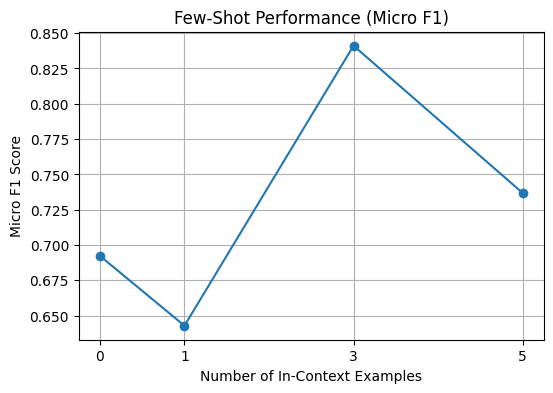

In [ ]:
shot_counts = [0, 1, 3, 5]
f1_results = []

for n_shots in shot_counts:
    f1 = evaluate_few_shot(n_shots=n_shots, num_samples=30)
    f1_results.append(f1)

plt.figure(figsize=(6, 4))
plt.plot(shot_counts, f1_results, marker='o')
plt.title("Few-Shot Performance (Micro F1)")
plt.xlabel("Number of In-Context Examples")
plt.ylabel("Micro F1 Score")
plt.grid(True)
plt.xticks(shot_counts)
plt.show()


## Analysis:
Few-shot improves results with good demonstrations. Also accuracy varies with shot count; diminishing returns seen after a point.
Improvement: Select demo samples using clustering or similarity. Also you may Tune number and selection strategy of shots.

## [BONUS] Random demonstration examples vs. selecting demonstration examples based on some criteria such as similarity and class labels.

In [7]:
from transformers import AutoTokenizer, AutoModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERT")
model = AutoModel.from_pretrained("UBC-NLP/MARBERT").eval().to(device)


In [8]:
def get_marbert_embedding(text):
    with torch.no_grad():
        tokens = tokenizer(
            text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=128
        ).to(device)

        outputs = model(**tokens)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        return cls_embedding.cpu()


In [14]:
train_embeddings = torch.cat([get_marbert_embedding(text) for text in X_train])

In [16]:
from torch.nn.functional import cosine_similarity

def get_similar_examples(text, k=3):
    query_embed = get_marbert_embedding(text).squeeze(0)
    sims = cosine_similarity(query_embed.unsqueeze(0), train_embeddings)[0]
    top_indices = torch.topk(sims, k).indices.tolist()
    return [(X_train[i], y_train[i]) for i in top_indices]


In [17]:
def evaluate_few_shot(n_shots=3, num_samples=30, strategy="random"):
    sample_indices = random.sample(range(len(X_val)), num_samples)
    sampled_texts = [X_val[i] for i in sample_indices]
    sampled_labels = [y_val[i] for i in sample_indices]

    predictions = []

    for review in tqdm(sampled_texts, desc=f"{n_shots}-shot | {strategy}"):
        if strategy == "random":
            example_indices = random.sample(range(len(X_train)), n_shots)
            examples = [(X_train[i], y_train[i]) for i in example_indices]
        elif strategy == "similar":
            examples = get_similar_examples(review, k=n_shots)

        prompt = build_few_shot_prompt(review, examples)
        gpt_output = query_gpt(prompt)
        pred = parse_gpt_response(gpt_output)
        predictions.append(pred)

    y_pred = np.array(predictions)
    y_true = np.array(sampled_labels)

    print(f"\n📊 Classification Report ({n_shots}-shot | {strategy}):")
    print(classification_report(y_true, y_pred, target_names=label_names))

    return f1_score(y_true, y_pred, average="micro")


In [30]:

strategies = ["random", "similar"]
results = {strategy: [] for strategy in strategies}
shot_counts = [0, 1, 3, 5]

for strategy in strategies:
    for n_shots in shot_counts:
        if n_shots == 0:
            # Zero-shot (no examples)
            def get_similar_examples(text, k): return []
        f1 = evaluate_few_shot(n_shots=n_shots, num_samples=30, strategy=strategy)
        results[strategy].append(f1)


0-shot | random: 100%|██████████| 30/30 [00:20<00:00,  1.48it/s]



📊 Classification Report (0-shot | random):
                     precision    recall  f1-score   support

         bug_report       0.78      0.88      0.82         8
improvement_request       0.86      0.67      0.75         9
             rating       0.89      0.71      0.79        24
             others       0.80      0.73      0.76        11

          micro avg       0.84      0.73      0.78        52
          macro avg       0.83      0.74      0.78        52
       weighted avg       0.85      0.73      0.78        52
        samples avg       0.87      0.80      0.80        52



1-shot | random: 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]



📊 Classification Report (1-shot | random):
                     precision    recall  f1-score   support

         bug_report       1.00      0.50      0.67         6
improvement_request       0.67      0.77      0.71        13
             rating       0.79      0.48      0.59        23
             others       0.58      0.58      0.58        12

          micro avg       0.70      0.57      0.63        54
          macro avg       0.76      0.58      0.64        54
       weighted avg       0.74      0.57      0.63        54
        samples avg       0.76      0.67      0.64        54



3-shot | random: 100%|██████████| 30/30 [00:19<00:00,  1.54it/s]



📊 Classification Report (3-shot | random):
                     precision    recall  f1-score   support

         bug_report       1.00      0.62      0.77         8
improvement_request       0.38      0.75      0.50         4
             rating       1.00      0.88      0.94        26
             others       0.62      0.45      0.53        11

          micro avg       0.82      0.73      0.77        49
          macro avg       0.75      0.68      0.68        49
       weighted avg       0.86      0.73      0.78        49
        samples avg       0.84      0.78      0.79        49



5-shot | random: 100%|██████████| 30/30 [00:20<00:00,  1.44it/s]



📊 Classification Report (5-shot | random):
                     precision    recall  f1-score   support

         bug_report       0.75      0.60      0.67        10
improvement_request       0.89      0.62      0.73        13
             rating       0.88      0.75      0.81        20
             others       0.55      0.43      0.48        14

          micro avg       0.78      0.61      0.69        57
          macro avg       0.77      0.60      0.67        57
       weighted avg       0.78      0.61      0.69        57
        samples avg       0.82      0.71      0.71        57



0-shot | similar: 100%|██████████| 30/30 [00:20<00:00,  1.47it/s]



📊 Classification Report (0-shot | similar):
                     precision    recall  f1-score   support

         bug_report       1.00      0.42      0.59        12
improvement_request       0.79      0.85      0.81        13
             rating       1.00      0.55      0.71        22
             others       0.50      0.60      0.55        10

          micro avg       0.79      0.60      0.68        57
          macro avg       0.82      0.60      0.66        57
       weighted avg       0.86      0.60      0.68        57
        samples avg       0.83      0.68      0.70        57



1-shot | similar: 100%|██████████| 30/30 [00:20<00:00,  1.49it/s]



📊 Classification Report (1-shot | similar):
                     precision    recall  f1-score   support

         bug_report       0.89      0.73      0.80        11
improvement_request       0.60      0.75      0.67         8
             rating       1.00      0.65      0.79        20
             others       0.55      0.60      0.57        10

          micro avg       0.77      0.67      0.72        49
          macro avg       0.76      0.68      0.71        49
       weighted avg       0.82      0.67      0.73        49
        samples avg       0.83      0.78      0.75        49



3-shot | similar: 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]



📊 Classification Report (3-shot | similar):
                     precision    recall  f1-score   support

         bug_report       1.00      0.82      0.90        11
improvement_request       0.71      0.83      0.77        12
             rating       1.00      0.57      0.73        21
             others       0.67      0.75      0.71         8

          micro avg       0.84      0.71      0.77        52
          macro avg       0.85      0.74      0.78        52
       weighted avg       0.88      0.71      0.77        52
        samples avg       0.89      0.79      0.79        52



5-shot | similar: 100%|██████████| 30/30 [00:26<00:00,  1.14it/s]


📊 Classification Report (5-shot | similar):
                     precision    recall  f1-score   support

         bug_report       0.83      0.45      0.59        11
improvement_request       0.86      0.55      0.67        11
             rating       0.93      0.58      0.72        24
             others       0.69      0.92      0.79        12

          micro avg       0.82      0.62      0.71        58
          macro avg       0.83      0.62      0.69        58
       weighted avg       0.85      0.62      0.70        58
        samples avg       0.85      0.70      0.74        58



Random few-shot prompting outperformed similarity-based selection overall. While similarity helped recall in some cases, it hurt precision—especially for rating and bug_report. Random examples offered better generalization across labels.

## [BONUS] Study the impact of ideas such as ordering of demonstration based on some criteria vs. random ordering.

In [ ]:
def build_few_shot_prompt(review, examples, order="random"):
    if order == "similarity":
        examples = sorted(
            examples,
            key=lambda ex: cosine_similarity(
                get_marbert_embedding(review),
                get_marbert_embedding(ex[0])
            ),
            reverse=True
        )
    elif order == "label":
        examples = sorted(
            examples,
            key=lambda ex: sum(ex[1]),  # sort by number of positive labels
            reverse=True
        )
    else:
        random.shuffle(examples)


    for ex_text, ex_labels in examples:
        ex_json = {
            "bug_report": bool(ex_labels[0]),
            "improvement_request": bool(ex_labels[1]),
            "rating": bool(ex_labels[2]),
            "others": bool(ex_labels[3])
        }
        prompt += f'Example:\nReview: "{ex_text}"\nOutput:\n{json.dumps(ex_json)}\n\n'

    prompt += f'Review: "{review}"\nOutput:\n'
    return prompt


In [35]:
def evaluate_few_shot(n_shots=3, num_samples=30, strategy="random", order="random"):
    sample_indices = random.sample(range(len(X_val)), num_samples)
    sampled_texts = [X_val[i] for i in sample_indices]
    sampled_labels = [y_val[i] for i in sample_indices]

    predictions = []

    for review in tqdm(sampled_texts, desc=f"{n_shots}-shot | {strategy} | {order}"):
            if strategy == "random":
                examples = random.sample(list(zip(X_train, y_train)), n_shots)
            elif strategy == "similar":
                examples = get_similar_examples(review, k=n_shots)

            prompt = build_few_shot_prompt(review, examples, order=order)
            gpt_output = query_gpt(prompt)
            pred = parse_gpt_response(gpt_output)
            predictions.append(pred)

    y_pred = np.array(predictions)
    y_true = np.array(sampled_labels)

    print(f"\n📊 Classification Report ({n_shots}-shot | {strategy}):")
    print(classification_report(y_true, y_pred, target_names=label_names))

    return f1_score(y_true, y_pred, average="micro")


3-shot | random | random: 100%|██████████| 30/30 [00:19<00:00,  1.55it/s]



📊 Classification Report (3-shot | random):
                     precision    recall  f1-score   support

         bug_report       0.85      0.73      0.79        15
improvement_request       0.63      0.92      0.75        13
             rating       0.79      0.58      0.67        19
             others       0.33      0.22      0.27         9

          micro avg       0.69      0.64      0.67        56
          macro avg       0.65      0.61      0.62        56
       weighted avg       0.69      0.64      0.65        56
        samples avg       0.73      0.71      0.69        56



3-shot | random | similarity: 100%|██████████| 30/30 [00:27<00:00,  1.07it/s]



📊 Classification Report (3-shot | random):
                     precision    recall  f1-score   support

         bug_report       0.70      0.70      0.70        10
improvement_request       0.79      0.79      0.79        14
             rating       0.85      0.65      0.73        17
             others       0.67      0.27      0.38        15

          micro avg       0.77      0.59      0.67        56
          macro avg       0.75      0.60      0.65        56
       weighted avg       0.76      0.59      0.65        56
        samples avg       0.77      0.60      0.63        56



3-shot | random | label: 100%|██████████| 30/30 [00:17<00:00,  1.68it/s]


📊 Classification Report (3-shot | random):
                     precision    recall  f1-score   support

         bug_report       0.75      0.82      0.78        11
improvement_request       0.40      0.80      0.53         5
             rating       0.93      0.76      0.84        17
             others       0.67      0.44      0.53         9

          micro avg       0.71      0.71      0.71        42
          macro avg       0.69      0.71      0.67        42
       weighted avg       0.76      0.71      0.72        42
        samples avg       0.79      0.76      0.75        42



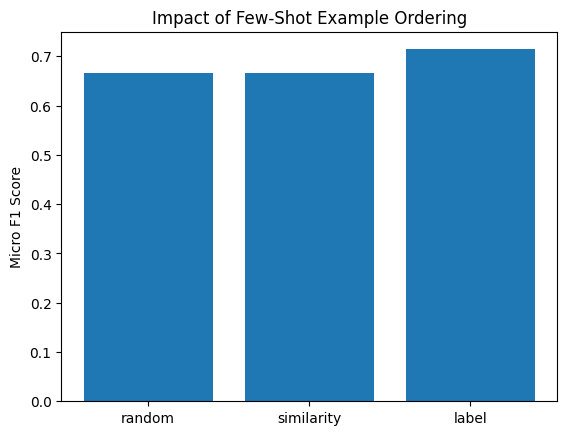

In [36]:
orders = ["random", "similarity", "label"]
results = {order: [] for order in orders}

for order in orders:
    f1 = evaluate_few_shot(n_shots=3, num_samples=30, strategy="random", order=order)
    results[order].append(f1)

# Plot
plt.bar(results.keys(), [r[0] for r in results.values()])
plt.title("Impact of Few-Shot Example Ordering")
plt.ylabel("Micro F1 Score")
plt.show()


Label-based ordering achieved the highest overall performance, with gains in recall and balanced F1 across labels. Similarity-based ordering did slightly worse, especially on "others", suggesting overly narrow context. Random ordering was competitive but less consistent. Ordering demonstrations by class diversity offers the best generalization.